# **Imbalance Classification with Credit Fraud Dataset**

In this notebook, we will study how classification should be done on unbalanced dataset.
* What is Unbalanced Data?
* With which models are unbalanced data trained?
* Which evaluation metric is correct to use in Unbalanced Data?

We will seek answers to these questions.

## Imbalanced Data

The number of examples that belong to each class may be referred to as the class distribution.

Imbalanced classification refers to a classification predictive modeling problem where the number of examples in the training dataset for each class label is not balanced. That is, where the class distribution is not equal or close to equal, and is instead biased or skewed. 

The abundance of examples from the majority class (or classes) can swamp the minority class. Most machine learning algorithms for classification predictive models are designed and demonstrated on problems that assume an equal distribution of classes. This means that a naive application of a model may focus on learning the characteristics of the abundant observations only, neglecting the examples from the minority class that is, in fact, of more interest and whose predictions are more valuable.

Ps: The class or classes with abundant examples are called the major or majority classes, whereas the class with few examples (and there is typically just one) is called the minor or minority class.

Many classification problems may have a severe imbalance in the class distribution. Some of those;
* Fraud Detection.
* Claim Prediction
* Default Prediction.
* Churn Prediction.
* Spam Detection.
* Anomaly Detection.
* Outlier Detection.
* Intrusion Detection
* Conversion Prediction.

## 1.Data Exploration

The problem we chose to examine the imbalanced classification in this notebook was credit card fraud. We will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. 

In [1]:
try:
  import warnings
  import time

  import numpy as np
  import pandas as pd
  import seaborn as sns
  import matplotlib.pyplot as plt

  from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
  from sklearn.model_selection import train_test_split, StratifiedKFold
  from sklearn.preprocessing import RobustScaler
  from imblearn.over_sampling import SMOTE

  from sklearn.linear_model import LogisticRegression
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
  from xgboost import XGBClassifier


  print("Libraries imported.")
except:
  print("Failed to import libraries!!")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Libraries imported.


In [2]:
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

In [ ]:
df.shape

(284807, 31)

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Time -> Number of seconds elapsed between this transaction and the first transaction in the dataset.

(V1-V28) -> may be result of a PCA Dimensionality reduction to protect user identities and sensitive features.

Amount -> Transaction amount

Class -> 1 for fraudulent transactions, 0 otherwise

**As described in the dataset, the features are scaled and the names of the features are not shown due to privacy reasons.**

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
print("Count of Missing Value is: "+ str(df.isna().sum().max()))

Count of Missing Value is: 0


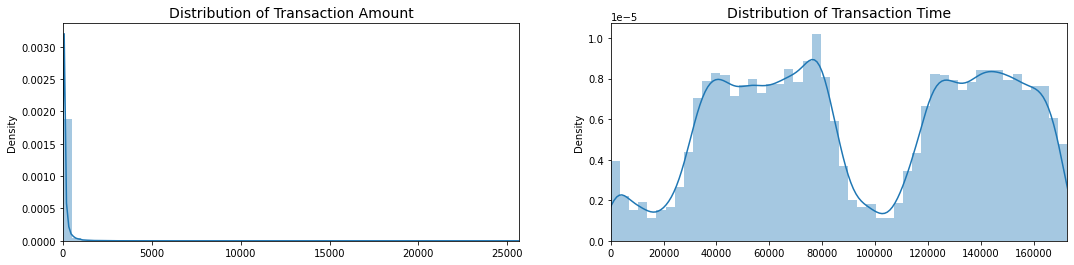

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0])
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(df.Amount.values), max(df.Amount.values)])

sns.distplot(time_val, ax=ax[1])
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(df.Time.values), max(df.Time.values)])



plt.show()

Text(0.5, 1.0, 'Class Value Count Distribution')

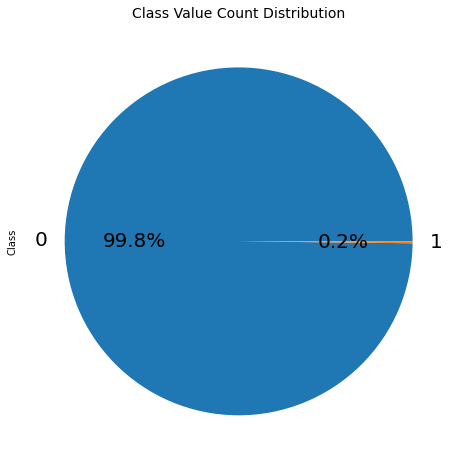

In [ ]:
df.Class.value_counts().plot.pie(autopct="%.1f%%",fontsize=20)
plt.title("Class Value Count Distribution", fontsize=14)

## 2.Data Preprocessing

Amount of the Credit Card Fraud dataset have very different scales and contain some very large outliers. These two characteristics lead to difficulties to visualize the data and, more importantly, they can degrade the predictive performance of many machine learning algorithms. Unscaled data can also slow down or even prevent the convergence of many gradient-based estimators.

# 2.1.Scaling

The centering and scaling statistics of RobustScaler is based on percentiles and are therefore not influenced by a few number of very large marginal outliers. 

In [4]:
scaler = RobustScaler()

df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

# 2.2.Split Data

Before proceeding with the Re-Sampling techniques we have to separate the orginal dataframe. Why? for testing purposes, remember although we are splitting the data when implementing Re-Sampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques. The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.

In [5]:
df_copy = df.copy()

y = df_copy.pop('Class')
X = df_copy

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X, y):
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

Xtrain = Xtrain.values
Xtest = Xtest.values
ytrain = ytrain.values
ytest = ytest.values

In [ ]:
print(Xtrain.shape)
print(Xtest.shape)

(227846, 30)
(56961, 30)


We prepared our dataset and performed the splitting operation. Now, before resampling, I want to show what happens when we give the imbalanced data set to the model. For this, we will use the XGBoost algorithm, which is one of the powerful classification models. Let's train the model and examine the output together.

In [ ]:
xgb = XGBClassifier()
xgb.fit(Xtrain, ytrain)
ypred = xgb.predict(Xtest)

accuracy = accuracy_score(ytest, ypred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.94%


**Here is that high accuracy value that caused us to go wrong.**

Now let's examine the inside of this accuracy value. Did he really learn with a balanced distribution? Or did he stay under the influence of the major class and achieve high success?

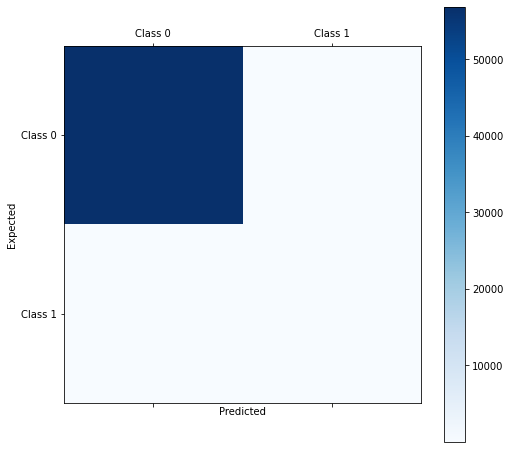

In [ ]:
conf_mat = confusion_matrix(y_true=ytest, y_pred=ypred)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

As we can see, the high accuracy rate is just an illusion. In this way, the selection of the metric used in imbalanced data sets is extremely important. Accuracy misleads us with imbalanced datasets.

## 4.Model 

In [ ]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model on X_train, y_train
    predicts on X_text, y_test 
    Calculate AUROC on predictions made on test data
    
    Outputs - AUROC score, time elapse for training and prediction    
    """
    start = time.time()
    model = model.fit(X_train, y_train)
    
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    
    end = time.time()
    time_elapsed = end - start
    
    return roc_score, time_elapsed

In [ ]:
SEED = 2
models = [("LogisticRegression", LogisticRegression(random_state=SEED)),
         ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=SEED)),
         ("RandomForestClassifier", RandomForestClassifier(random_state=SEED)),
         ("GradientBoostingClassifier", GradientBoostingClassifier(random_state=SEED)),
         ("AdaBoostClassifier", AdaBoostClassifier(random_state=SEED)),
         ("XGBClassifier",XGBClassifier(random_state=SEED))]

## 4.Re-Sampling

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

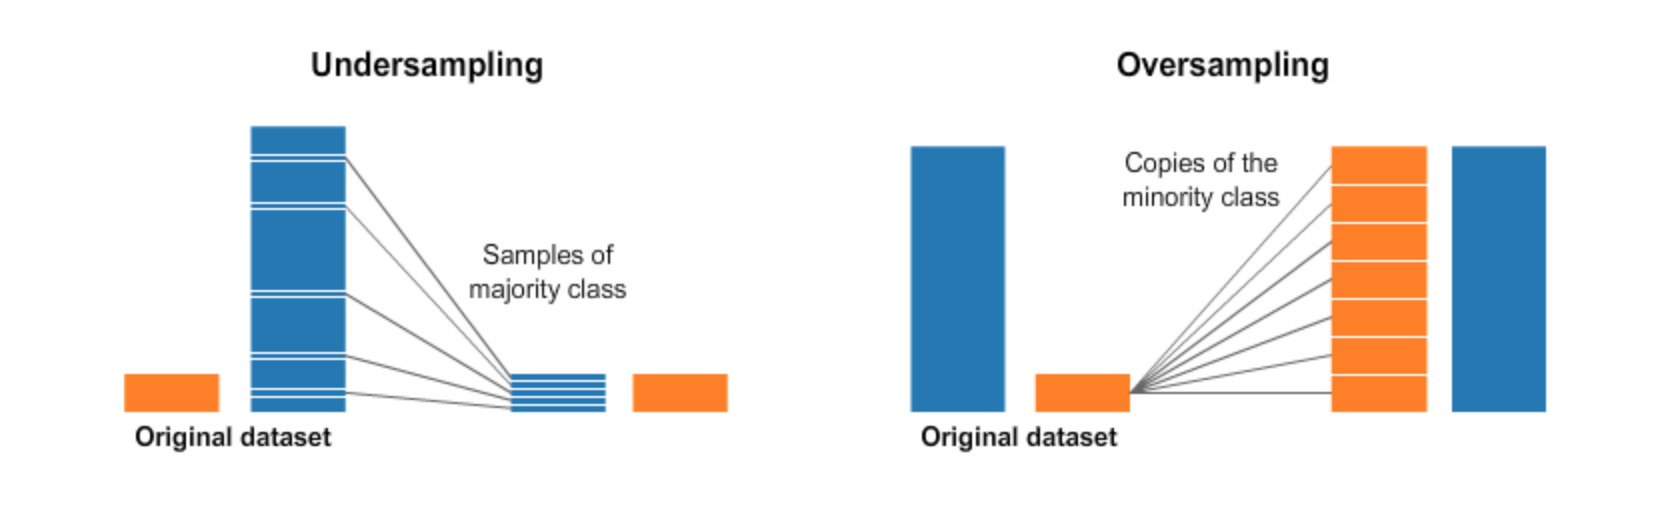

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

Under-sampling is usually applied when we have enough data (not a ratio). If we have enough data for minority classes, then we can choose random elements in the majority class to equalize the ratio.

Over-sampling is usually applied if there is not enough data in the minority class. But one of the disadvantages of over sampling is that it causes overfitting.

In [ ]:
count_class_0, count_class_1 = df.Class.value_counts()

# Divide by class
df_class_0 = df[df['Class'] == 0]
df_class_1 = df[df['Class'] == 1]

### 3.1.Random Under-Sampling

Random under-sampling:
1    492
0    492
Name: Class, dtype: int64


Text(0.5, 1.0, 'Class Value Count Distribution')

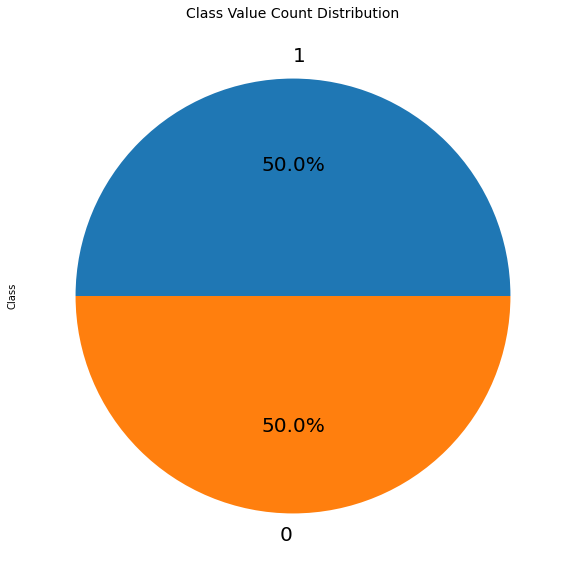

In [ ]:
df_class_0_under = df_class_0.sample(count_class_1)
df_random_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_random_under.Class.value_counts())

df_random_under.Class.value_counts().plot.pie(autopct="%.1f%%",fontsize=20)
plt.title("Class Value Count Distribution", fontsize=14)

In [ ]:
df_random_under_copy = df_random_under.copy()
y = df_random_under_copy.pop('Class')
X = df_random_under_copy

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X, y):
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

Xtrain = Xtrain.values
Xtest = Xtest.values
ytrain = ytrain.values
ytest = ytest.values

In [ ]:
results = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, Xtrain, ytrain, Xtest, ytest)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
    results["Time_in_sec"].append(time_)

In [ ]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.974282,0.0455801
1,DecisionTreeClassifier,0.903061,0.0281172
2,RandomForestClassifier,0.977509,0.358124
3,GradientBoostingClassifier,0.961266,0.748596
4,AdaBoostClassifier,0.92222,0.255728
5,XGBClassifier,0.95606,0.165582


Text(5    0.95606
Name: AUCROC_score, dtype: object, 5    0.165582
Name: Time_in_sec, dtype: object, 'XGB')

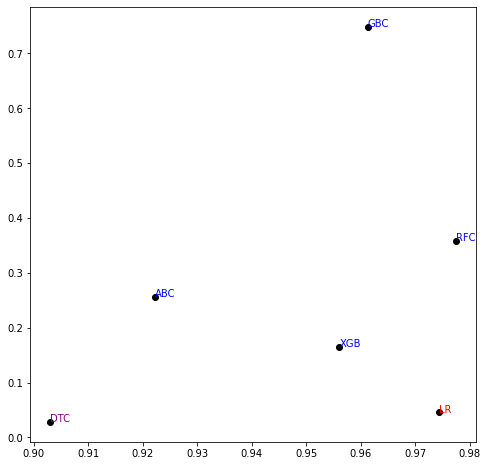

In [ ]:
plt.plot(results.AUCROC_score, results.Time_in_sec, 'o', color='black',label=results.Model)
plt.text(results.AUCROC_score[results.Model=='LogisticRegression'],
         results.Time_in_sec[results.Model=='LogisticRegression'],"LR", color='red')
plt.text(results.AUCROC_score[results.Model=='DecisionTreeClassifier'],
         results.Time_in_sec[results.Model=='DecisionTreeClassifier'],"DTC", color='purple')
plt.text(results.AUCROC_score[results.Model=='RandomForestClassifier'],
         results.Time_in_sec[results.Model=='RandomForestClassifier'],"RFC", color='blue')
plt.text(results.AUCROC_score[results.Model=='GradientBoostingClassifier'],
         results.Time_in_sec[results.Model=='GradientBoostingClassifier'],"GBC", color='blue')
plt.text(results.AUCROC_score[results.Model=='AdaBoostClassifier'],
         results.Time_in_sec[results.Model=='AdaBoostClassifier'],"ABC", color='blue')
plt.text(results.AUCROC_score[results.Model=='XGBClassifier'],
         results.Time_in_sec[results.Model=='XGBClassifier'],"XGB", color='blue')

### 3.2.Random Over-Sampling

Random over-sampling:
1    284315
0    284315
Name: Class, dtype: int64


Text(0.5, 1.0, 'Class Value Count Distribution')

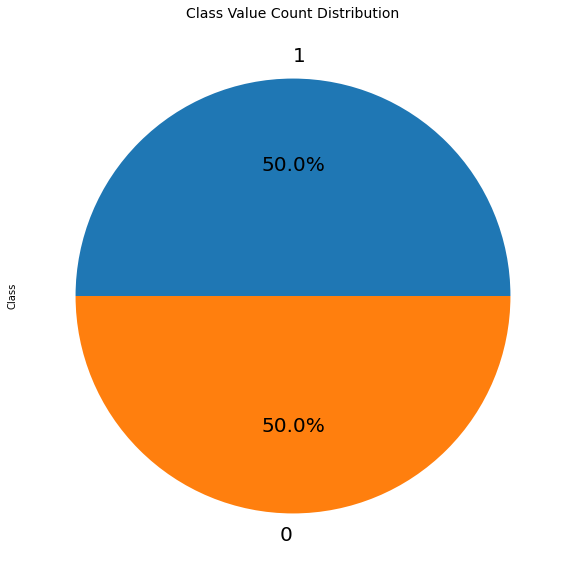

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_random_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_random_over.Class.value_counts())

df_random_over.Class.value_counts().plot.pie(autopct="%.1f%%",fontsize=20)
plt.title("Class Value Count Distribution", fontsize=14)

In [ ]:
df_random_over_copy = df_random_over.copy()

y = df_random_over_copy.pop('Class')
X = df_random_over_copy

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X, y):
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

Xtrain = Xtrain.values
Xtest = Xtest.values
ytrain = ytrain.values
ytest = ytest.values

In [ ]:
results = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, Xtrain, ytrain, Xtest, ytest)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
    results["Time_in_sec"].append(time_)

In [ ]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.984621,8.80355
1,DecisionTreeClassifier,0.578179,15.4636
2,RandomForestClassifier,1,226.745
3,GradientBoostingClassifier,0.96357,538.794
4,AdaBoostClassifier,0.301862,109.529
5,XGBClassifier,0.950594,96.5375


Text(5    0.950594
Name: AUCROC_score, dtype: object, 5    96.5375
Name: Time_in_sec, dtype: object, 'XGB')

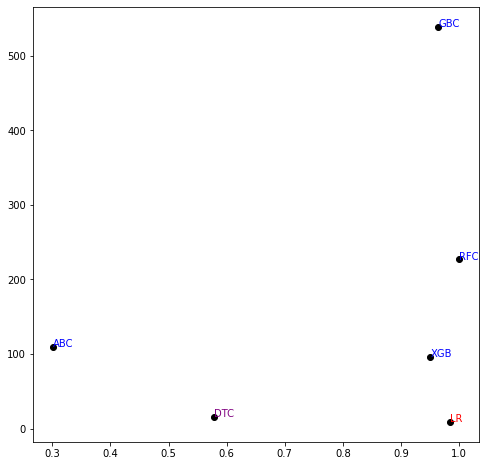

In [ ]:
plt.plot(results.AUCROC_score, results.Time_in_sec, 'o', color='black',label=results.Model)
plt.text(results.AUCROC_score[results.Model=='LogisticRegression'],
         results.Time_in_sec[results.Model=='LogisticRegression'],"LR", color='red')
plt.text(results.AUCROC_score[results.Model=='DecisionTreeClassifier'],
         results.Time_in_sec[results.Model=='DecisionTreeClassifier'],"DTC", color='purple')
plt.text(results.AUCROC_score[results.Model=='RandomForestClassifier'],
         results.Time_in_sec[results.Model=='RandomForestClassifier'],"RFC", color='blue')
plt.text(results.AUCROC_score[results.Model=='GradientBoostingClassifier'],
         results.Time_in_sec[results.Model=='GradientBoostingClassifier'],"GBC", color='blue')
plt.text(results.AUCROC_score[results.Model=='AdaBoostClassifier'],
         results.Time_in_sec[results.Model=='AdaBoostClassifier'],"ABC", color='blue')
plt.text(results.AUCROC_score[results.Model=='XGBClassifier'],
         results.Time_in_sec[results.Model=='XGBClassifier'],"XGB", color='blue')

As you can see, we have achieved very high success values. But this is a misleading value. Because we had quite a few minor class data. Duplicating the same data over and over caused overfitting.

### 3.3.SMOTE(Synthetic Minority Oversampling Technique)

In [6]:
sm = SMOTE(random_state=2)
X_train_smo, y_train_smo = sm.fit_sample(Xtrain, ytrain.ravel())

In [9]:
results = {"Model":[],
          "AUCROC_score":[],
          "Time_in_sec":[]}

for name, model in models:
    roc, time_ = train_and_predict(model, X_train_smo, y_train_smo, Xtest, ytest)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)
    results["Time_in_sec"].append(time_)

In [10]:
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score,Time_in_sec
0,LogisticRegression,0.981361,9.00039
1,DecisionTreeClassifier,0.499472,51.7634
2,RandomForestClassifier,0.947876,391.962
3,GradientBoostingClassifier,0.970144,810.096
4,AdaBoostClassifier,0.955761,152.22
5,XGBClassifier,0.980274,118.678


Text(5    0.980274
Name: AUCROC_score, dtype: object, 5    118.678
Name: Time_in_sec, dtype: object, 'XGB')

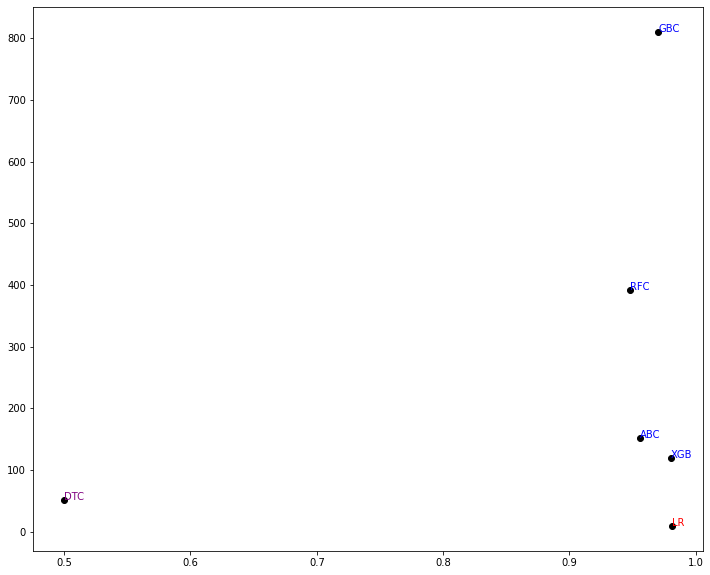

In [11]:
plt.plot(results.AUCROC_score, results.Time_in_sec, 'o', color='black',label=results.Model)
plt.text(results.AUCROC_score[results.Model=='LogisticRegression'],
         results.Time_in_sec[results.Model=='LogisticRegression'],"LR", color='red')
plt.text(results.AUCROC_score[results.Model=='DecisionTreeClassifier'],
         results.Time_in_sec[results.Model=='DecisionTreeClassifier'],"DTC", color='purple')
plt.text(results.AUCROC_score[results.Model=='RandomForestClassifier'],
         results.Time_in_sec[results.Model=='RandomForestClassifier'],"RFC", color='blue')
plt.text(results.AUCROC_score[results.Model=='GradientBoostingClassifier'],
         results.Time_in_sec[results.Model=='GradientBoostingClassifier'],"GBC", color='blue')
plt.text(results.AUCROC_score[results.Model=='AdaBoostClassifier'],
         results.Time_in_sec[results.Model=='AdaBoostClassifier'],"ABC", color='blue')
plt.text(results.AUCROC_score[results.Model=='XGBClassifier'],
         results.Time_in_sec[results.Model=='XGBClassifier'],"XGB", color='blue')

## REFERENCE

* https://machinelearningmastery.com/what-is-imbalanced-classification/
* https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
* https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
* https://www.kaggle.com/qianchao/smote-with-imbalance-data
* https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
* https://www.kaggle.com/imsanjoykb/data-visualization-tutorial-matplotlib-seaborn
* https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data

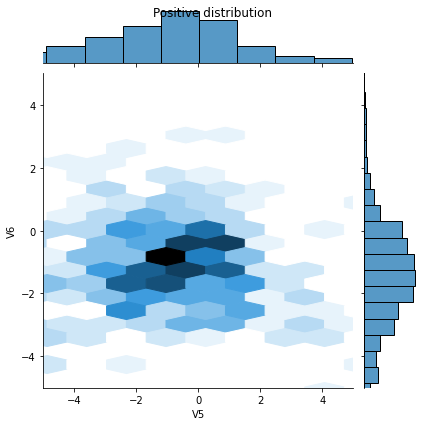

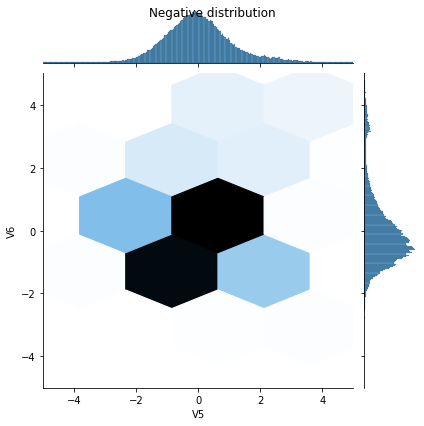

In [ ]:
sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex',xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")